In [1]:
import math, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Global utilities
ureg    = pint_pandas.PintType.ureg
dtime_t = pd.to_timedelta(1, unit='s')

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_csv_mec(path, pint=True):
    '''Import Mecmesin data'''
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

def read_csv_dmm(path, pint=True, first_error=False):
    '''Import DMM data'''
    df = pd.read_csv(path, header=[0,1], index_col=[0])
    if pint:
        df = df.pint.quantify(-1)
    if first_error:
        df = df.iloc[1:]
    return df

def pint2dtime(times):
    '''Converts Pint time values to Pandas deltatime.'''
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        # Strip "pint[...]" text wrapping the unit string.
        unit = str(times.dtype)[5:-1]
    )

def event_times(event_coding):
    '''Extracts event start times from Mecmesin event coding.'''
    return event_coding[event_coding.diff() == -1].index

def time2state(times, events):
    '''
    Labels each time with an associated state based on Mecmesin event start times.
    I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
    '''
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

# User inputs
pressure_area = math.pi * (6.2 * ureg.mm / 2)**2
inf_threshold = 1e30 * ureg.ohm
data = [
    dotdict(
        mec_csv = 'testing/fsr 1s 1s 2mms 2n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/fsr.dmm.csv',
        label   = 'COTS FSR',
    ),
    dotdict(
        mec_csv = 'testing/sensor1 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor1.dmm.csv',
        label   = 'Sensor 1',
    ),
    dotdict(
        mec_csv = 'testing/sensor2 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor2.dmm.csv',
        label   = 'Sensor 2',
    ),
    dotdict(
        mec_csv = 'testing/sensor3 1s 1s 2mms 7.5n 0 9 50hz.mec.csv',
        dmm_csv = 'testing/sensor3.dmm.csv',
        label   = 'Sensor 3',
    ),
    # dotdict(
    #     mec_csv = 'testing/sensor4 1s 1s 2mms 9n 0 9 50hz.mec.csv',
    #     dmm_csv = 'testing/sensor4.dmm.csv',
    #     label   = 'sensor4 1s 1s 2mms 9n 0 9 50hz',
    # ),
    # dotdict(
    #     mec_csv = 'testing/sensor4 1s 1s 2mms 9n 0 9 50hz test2.mec.csv',
    #     dmm_csv = 'testing/sensor4_test2.dmm.csv',
    #     label   = 'sensor4 1s 1s 2mms 9n 0 9 50hz test2',
    # ),
]

for dat in data:
    dat.mec_df = read_csv_mec(dat.mec_csv)
    dat.dmm_df = read_csv_dmm(dat.dmm_csv)

    dat.mec_df.index = pint2dtime(dat.mec_df.Time)
    dat.events = event_times(dat.mec_df.Event)
    dat.dmm_df.index = pint2dtime(dat.dmm_df.Time - dat.dmm_df.Time.iloc[0]) + dat.events[0]

max_sample_time = max([
    df.index.to_series().diff().max()
    for df in [dat.mec_df for dat in data] + [dat.dmm_df for dat in data]
])

for dat in data:
    dat.df = pd.concat(
        [
            dat.mec_df.resample(max_sample_time).mean()[['Force', 'Distance']],
            dat.dmm_df.resample(max_sample_time, offset=-dat.events[0]).mean()[['Resistance']]
        ],
        axis=1
    )

    # Strip data outside range of interest
    # dat.df = dat.df[(dat.df.Force >= 1*ureg.N) & (dat.df.Force <= 6*ureg.N)]

    # Condition data
    dat.df.loc[dat.df.Resistance >= inf_threshold, 'Resistance'] = pd.NA
    dat.df['ResNorm'] = dat.df.Resistance / dat.df.Resistance.max()
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)

    # Create Pint-unitless data copy to suppress Pyplot errors
    dat.dq = dat.df.pint.dequantify()
    # Remove unit headers from dequantify(). These cause problems with column access.
    dat.dq.columns = dat.dq.columns.droplevel(-1)

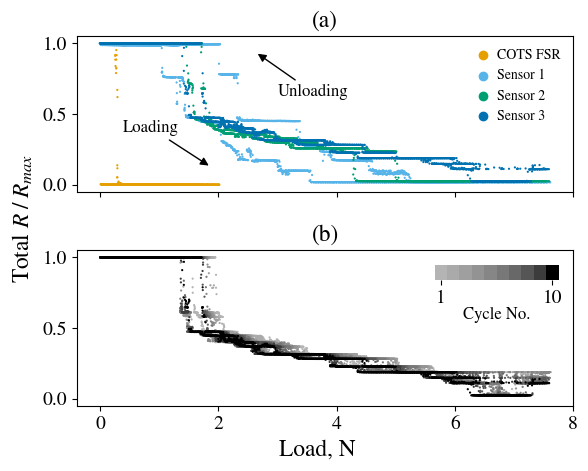

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

# palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Wong 2011 color blind accessible palette
palette = [
    '#E69F00',
    '#56B4E9',
    '#009E73',
    # '#F0E442',
    '#0072B2',
    '#D55E00',
    '#CC79A7',
]

# Greyscale ramp for better human perception
# https://observablehq.com/@anandaroop/perceptually-tuned-grayscale-ramps
def greyscale_ramp(x, k=0.5):
    ramp = (x * 100)**(k)
    max_ramp = 100**k
    return ramp / max_ramp

mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'

interest_cycle = 9
interest_data = 3

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.375)
fig.supxlabel('Load, N', y=-0.005)
fig.supylabel('Total $R\\;/\\;R_{max}$')

# axs[0].set_title(f'(a) Cycle {1 + interest_cycle}, All Sensors')
axs[0].set_title('(a)', y=1.01)
axs[0].legend([axs[0].scatter(np.NaN, np.NaN, c=palette[i]) for i in range(len(data))], [dat.label for dat in data], handletextpad=0, frameon=False, prop={'size': 10})
# Draw loading/unloading arrows
axs[0].annotate('Loading', xytext=(0.375, 0.375), xy=(1.875, 0.125), arrowprops=dict(arrowstyle='-|>', color='black'), size=12)
axs[0].annotate('Unloading', xytext=(3, 0.625), xy=(2.625, 0.9375), arrowprops=dict(arrowstyle='-|>', color='black'), size=12)
# Plot data
for dat, i in zip(data, itertools.count()):
    df = dat.dq.dropna()
    df = df[df.Cycle == interest_cycle]
    ResNormNorm = df.ResNorm / df.ResNorm.max() # Retrieve normalized response wrt single cycle of interest
    axs[0].scatter(df.Force, ResNormNorm, marker='.', c=palette[i], edgecolor='none', s=10)

# axs[1].set_title(f'(b) Sensor {interest_data}, All Cycles')
axs[1].set_title('(b)', y=1.01)
# Plot data
grp = data[interest_data].dq.dropna().groupby('Cycle')
greyscale = greyscale_ramp(np.linspace(0.5, 0, len(grp)))
for (i, df), alpha in zip(grp, greyscale):
    axs[1].scatter(df.Force, df.ResNorm, marker='.', c=str(alpha), edgecolor='none', s=10)
# Draw gradient legend
grad_cmap = LinearSegmentedColormap.from_list('greyscale', [[c]*3 for c in greyscale], N=len(grp))
grad_axin = inset_axes(axs[1], width='25%', height='10%', loc='upper right', borderpad=0.75)
grad_axin.set_frame_on(False)
grad = plt.colorbar(plt.cm.ScalarMappable(cmap=grad_cmap, norm=plt.Normalize(vmin=0, vmax=1)), cax=grad_axin, orientation='horizontal')
grad.ax.set_xticks([1/len(grp)/2, 1 - 1/len(grp)/2], ['1', '10'])
grad.ax.set_xlabel('Cycle No.', fontsize=12, labelpad=0)

plt.savefig('plot.png', dpi=900, bbox_inches='tight')
plt.show()